# 7333 - Quantifying the World
# Unit 8 Case Study
# Authors: Brandon De La Houssaye, Bruce Granger, Daniel Serna

Required Packages

In [1]:
import pandas_profiling
import pandas as pd
from pathlib import Path

In [3]:
config = Path('./wmt.csv')

if config.is_file():
    wmt_data = pd.read_csv("wmt.csv")
else:
    # import yahoo_fin
    # import requests_html
    from yahoo_fin import stock_info as si
    Start_Date = '10/15/2015'; End_Date = '10/15/2019'
    wmt_data = si.get_data("wmt", start_date = Start_Date, end_date = End_Date)
    wmt_data.to_csv("wmt.csv", index=False)

In [4]:
wmt_data.head()

,open,high,low,close,adjclose,volume,ticker
0,59.700001,60.470001,58.610001,59.330002,53.602409,46253500.0,WMT
1,59.470001,59.490002,58.369999,58.889999,53.204887,26195100.0,WMT
2,58.790001,59.299999,58.500000,58.849998,53.168743,17805800.0,WMT
3,58.860001,59.000000,58.570000,58.750000,53.078396,10423700.0,WMT
4,58.799999,59.040001,58.570000,58.639999,52.979023,13117600.0,WMT


In [5]:
wmt_data_1=wmt_data.drop(columns = ['volume'])

In [6]:
wmt_data_2=wmt_data.drop(columns = ['open','high','low','close','volume'])

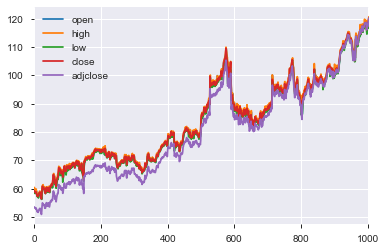

In [7]:
ax = wmt_data_1.plot()

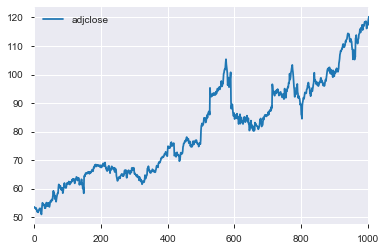

In [8]:
ax1=wmt_data_2.plot()

WMT Profile

In [9]:
profile = pandas_profiling.ProfileReport(wmt_data)
profile

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
   for param_seasonal in seasonal_pdq:
       try:
           mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
           results = mod.fit()
           print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
       except:
           continue